# From Pixels to Insights: Demystifying Vision Transformers for Image-based Machine Learning ; Hands-on section

## Corning - Merck symposium 2023

The following sections are covered in the notebook:

* Loading benchmark vision datasets
* Loading pre-trained Vision Transformer (ViT) models
* Fine-tuning a ViT model using new dataset
* Understanding the working of attention layers
* Understanding the inner components of a vision transformer model

- Original vision transformer paper: Alexey Dosovitskiy et al., "An Image Is Worth 16x16 Words: Transformers for Image Recognition at Scale",
https://arxiv.org/abs/2010.11929

Some of the cells in this notebook: https://colab.research.google.com/github/hirotomusiker/schwert_colab_data_storage/blob/master/notebook/Vision_Transformer_Tutorial.ipynb

### Install and load the required libraries

In [277]:
import torch                                # PyTorch library
import torchvision                          # Library from PyTorch project that contains popular vision datasets, 
                                            # vision models, and image transformations
from torch.utils.data import Subset         # Module needed to select a subset of dataset
from matplotlib import pyplot as plt        # Image and plot visualization
import numpy as np                          # Library to handle arrays and algebraic computations
import PIL                                  # Library to handle image I/O
from skimage.transform import resize        # Utility to resize input image


try:
    import timm
    from timm import create_model           # PyTorch Image Models (TIMM) is a collection of pre-trained image models and 
except:                                     # methods required for training ML models
    !pip install timm
    import timm
    from timm import create_model  

### Setting up the training dataset

In [ ]:
#---------Define the necessary image transformations--------#

transform1 = torchvision.transforms.ToTensor()                   # Method that transforms the image format to PyTorch tensor
transform2 = torchvision.transforms.Resize((224,224))            # Method that resizes a RGB image to (224,224,3) 

transform = torchvision.transforms.Compose([transform1, transform2])   # Compose the two transforms into one master transform.

#---------Download the CIFAR 10 dataset-------------------#
traindata_full = torchvision.datasets.CIFAR10('./cifar10_root/', download=True, train = True, transform = transform)

#---------Overview of the dataset--------------------------#
# Number of data
num_train_data = len(traindata_full)
print('Number of images in the CIFAR10 dataset:', num_train_data)

# Number of classes
num_classes = len(traindata_full.classes)
print('Number of classes in the CIFAR10 dataset:', num_classes)

In [ ]:
#------Manually defining the class labels in the CIFAR100 dataset-------#

class_dict = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 
              6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [ ]:
#---------------Setting up the dataloader for training----------------#

indices = list(range(100))                                    
traindata = Subset(traindata_full, indices)                   # Selecting the first 100 images from the whole dataset
trainloader = torch.utils.data.DataLoader(traindata, batch_size=4,shuffle=True, num_workers=1)  #batch size = 4


#----------------Visualizing images in the dataset--------------#
def imshow(img):                                              # Function to visualize image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))                # Transforming images from (channels, height, width) to (h,w,c)
    plt.show()

dataiter = iter(trainloader)                                  # Iterable trainloader

for _ in range(3):                                            # Visualizing 3 batches of images (batch size = 4)
    print(_)
    images, labels = next(dataiter)                           # The 'next' attribute helps to move to the next batch
    imshow(torchvision.utils.make_grid(images))               # torchvision method that allows visualizing images in a grid
    print([class_dict[label.item()] for label in labels])

### Setting up the model

In [ ]:
#---------------A sneak peek at the overall list of models in timm------------#

models = timm.list_models('*', pretrained = True)                             # Select all the models in timm
print("Random selection of 10 models from the overall list of models:\n")
print([models[i] for i in torch.randperm(len(models))[:10].tolist()])         # Select 10 random models from the list to display
print("\n")

vit_models = timm.list_models('vit*', pretrained = True)                      # Select all the vit models in timm
print("Random selection of 10 models from the overall list of vit models:\n")
print([vit_models[i] for i in torch.randperm(len(vit_models))[:10].tolist()]) # Select 10 random models from the list to display
print("\n")

In [ ]:
#-------------------------Defining the model-----------------------------------#

model_name = 'vit_base_patch16_224'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
model = create_model(model_name, pretrained = True, num_classes = 10).to(device)

### Training the model

In [ ]:
loss_criterion = torch.nn.CrossEntropyLoss()                              # Cross-entropy loss is the loss criterion
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)   # SGD is the optimizer
num_epochs = 4                                                            # Number of training epochs

In [ ]:
for epoch in range(num_epochs): 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data                                             # get the inputs; data is a list of [inputs, labels]
        optimizer.zero_grad()                                             # zero the parameter gradients for the fresh epoch

        outputs = model(inputs)                                           # Feed forward step
        loss = loss_criterion(outputs, labels)                            # Compute the loss 
        loss.backward()                                                   # Backward propagation
        optimizer.step()                                                  # Update model parameter weights

        running_loss += loss.item()
        if i % 20 == 0:                                                   # print every 10 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

### Model Inference and explanation

In [94]:
model_name = 'vit_base_patch16_224'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
model = create_model(model_name, pretrained = True).to(device)

device =  cpu


In [425]:
#---------Define the necessary image transformations--------#

transform1 = torchvision.transforms.ToTensor()                   # Method that transforms the image format to PyTorch tensor
transform2 = torchvision.transforms.Resize((224,224))            # Method that resizes a RGB image to (224,224,3) 
normalize_mean = (0.5, 0.5, 0.5)
normalize_std = (0.5, 0.5, 0.5)        
transform3 = torchvision.transforms.Normalize(normalize_mean, normalize_std)

transforms = torchvision.transforms.Compose([transform1, transform2, transform3])   # Compose the two transforms into one master transform.

--2023-11-07 09:50:56--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.80.59, 142.250.80.123, 142.251.40.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.80.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt.73’

100%[======================================>] 21,675      --.-K/s   in 0.02s   

2023-11-07 09:50:56 (1.14 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt.73’ saved [21675/21675]



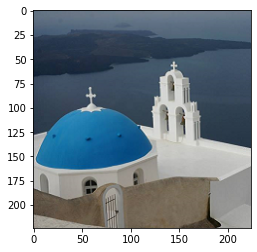

In [426]:
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

img = PIL.Image.open('santorini.png') 
img_tensor = transforms(img).unsqueeze(0).to(device)

img = np.array(img)
img = resize(img, (224, 224, 3))

plt.imshow(img)
plt.show()

output = model(img_tensor)                     # Obtain output from the model for this image

In [427]:
#-----------Visualizing the test image and the model prediction-----------#
print(f"Inference Result: {imagenet_labels[int(torch.argmax(output))], int(torch.argmax(output))}")

Inference Result: ('church, church_building\n', 497)


### Understanding Vision Transformers: Images as sequence of patches

* Original shape of image: (224,224)

* Divide them into patches of (16,16) -> 196 patches, each of shape (16,16)

* Flatten each patch into a 1-D sequence -> 196 patches, each of size 256

* Embed each patch into 768 dimensions using a linear layer -> 196 patches, each of size 768

In [428]:
patches = model.patch_embed(img_tensor)                      # Converting input image into sequence of patches and embed them
print("Shape of input image tensor: ", img_tensor.shape)                 
print("Shape of sequence of patches: ", patches.shape)

Shape of input image tensor:  torch.Size([1, 3, 224, 224])
Shape of sequence of patches:  torch.Size([1, 196, 768])


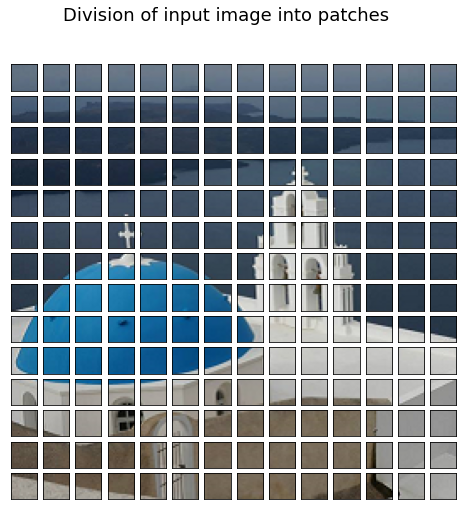

In [429]:
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Division of input image into patches", fontsize=18)
img = np.asarray(img) #np.asarray(image.permute(1,2,0).numpy())
for i in range(0, 196):                                      # Looping through each patch
    x = i % 14                                               # Calculating the position of the patch in the 1st-dimension
    y = i // 14                                              # Calculating the position of the patch in the 2nd-dimension
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]                # Extracting the patch from the input image
    ax = fig.add_subplot(14, 14, i+1)                        # Displaying the patch in the grid of plots
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

### Add position embeddings (pos emb)

* Position embeddings are required to enable the model to learn which patches are in the local neighborhood, and which ones are in the global neighborhood.

* This is especially relevant because the image is represented as a 1D-list of patches, and this representation does not inherently contain the 2D spatial awareness.

* Position embedding is a vector of length 768 associated with each patch.

* A well-learned position embedding should show similar embedding for patches that are close by in the 2D arrangement of patches.

In [430]:
pos_embed = model.pos_embed                                               # Extract the pos emb from the model
print("Shape of the position embedding: ", pos_embed.shape)            

Shape of the position embedding:  torch.Size([1, 197, 768])


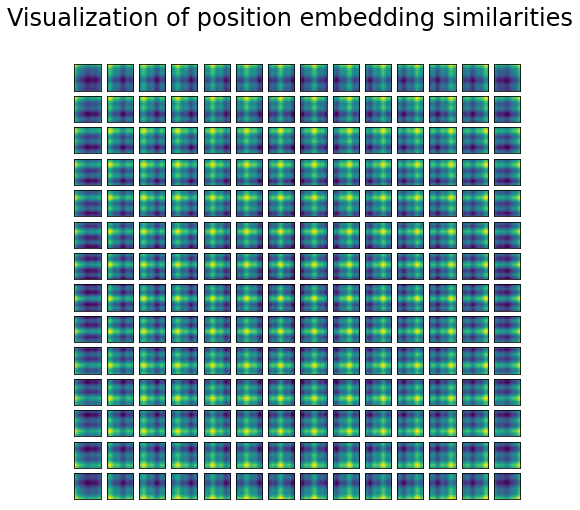

In [431]:
#------Defining the cosine similarity function that will be used to compare the pos emb of the patches--------#
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)                         

fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=24)

for i in range(1, pos_embed.shape[1]):           # Looping through each patch's pos emb
    # A similarity score is computed between this pos emb and every other pos emb
    # So, 196 similarity scores are computed for each pos emb.
    sim = torch.nn.functional.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

### Prepare the input for the transformer

* An additional patch (referred to as the class patch or the class token) is appended to the list of patches.

* This patch will be fed forward along with the rest of the patches. After the transformer layers, the class patch will be used as input for the part of the model that does classification.

In [432]:
transformer_input = torch.cat((model.cls_token, patches), dim=1)         # Add class patch to list of image patches
transformer_input = transformer_input + pos_embed                        # Add pos emb
print("Shape of the transformer input: ", transformer_input.shape)

Shape of the transformer input:  torch.Size([1, 197, 768])


### Schematic of the model architecture

### Transformer Encoder

In [433]:
print("Input tensor to Transformer (z0): ", transformer_input.shape)
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
    print("Entering the transformer encoder {}".format(i))
    x = blk(x)
    print(f"Output from transformer encoder {i}:", x.shape)
x = model.norm(x)
transformer_output = x[:, 0]
print("Output vector from Transformer (z12-0):", transformer_output.shape)

Input tensor to Transformer (z0):  torch.Size([1, 197, 768])
Entering the transformer encoder 0
Output from transformer encoder 0: torch.Size([1, 197, 768])
Entering the transformer encoder 1
Output from transformer encoder 1: torch.Size([1, 197, 768])
Entering the transformer encoder 2
Output from transformer encoder 2: torch.Size([1, 197, 768])
Entering the transformer encoder 3
Output from transformer encoder 3: torch.Size([1, 197, 768])
Entering the transformer encoder 4
Output from transformer encoder 4: torch.Size([1, 197, 768])
Entering the transformer encoder 5
Output from transformer encoder 5: torch.Size([1, 197, 768])
Entering the transformer encoder 6
Output from transformer encoder 6: torch.Size([1, 197, 768])
Entering the transformer encoder 7
Output from transformer encoder 7: torch.Size([1, 197, 768])
Entering the transformer encoder 8
Output from transformer encoder 8: torch.Size([1, 197, 768])
Entering the transformer encoder 9
Output from transformer encoder 9: torch

### Using attention mechanism for explaining model prediction

In [543]:
print("Transformer Multi-head Attention block:")
layer_no = 11
if layer_no == 0:
    x = transformer_input.clone()
    attention = model.blocks[layer_no].attn
    print(attention)
    transformer_input_expanded = attention.qkv(x)[0]
    print("input of the transformer encoder:", transformer_input.shape)
    print("expanded to: ", transformer_input_expanded.shape)
else:
    x = transformer_input.clone()
    for n in range(layer_no):
        x = model.blocks[n](x)
    attention = model.blocks[layer_no].attn
    print(attention)
    transformer_input_expanded = attention.qkv(x)[0]
    print("input of the transformer encoder:", transformer_input.shape)
    print("expanded to: ", transformer_input_expanded.shape)

Transformer Multi-head Attention block:
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (q_norm): Identity()
  (k_norm): Identity()
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
input of the transformer encoder: torch.Size([1, 197, 768])
expanded to:  torch.Size([197, 2304])


In [544]:
# Split qkv into mulitple q, k, and v vectors for multi-head attantion
qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  # (N=197, (qkv), H=12, D/H=64)
print("split qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2)  
kT = k.permute(0, 2, 1)  
print("transposed ks: ", kT.shape)

attention_matrix = q @ kT
print("attention matrix: ", attention_matrix.shape)

split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])
attention matrix:  torch.Size([12, 197, 197])


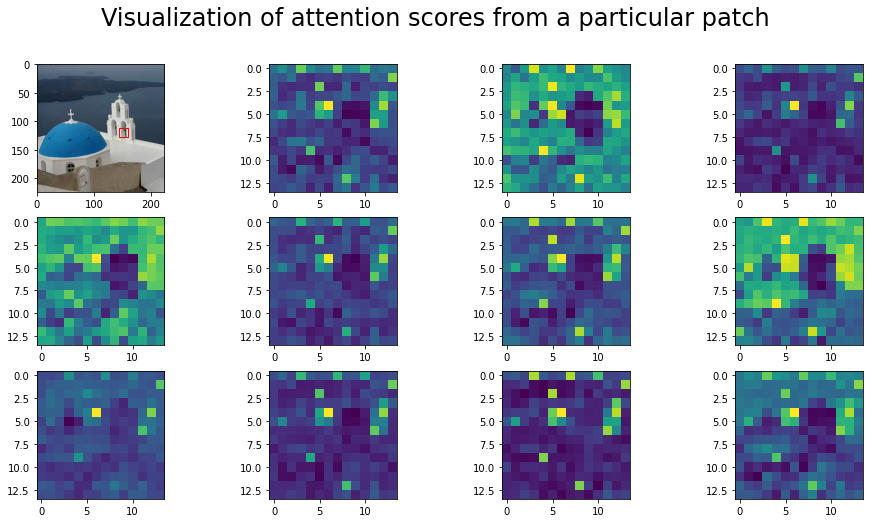

In [547]:
import matplotlib.patches as patches        # Utility to draw shapes onto an existing image
# Visualize attention matrix
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of attention scores from a particular patch", fontsize=24)
img = np.asarray(img)
ax = fig.add_subplot(3, 4, 1)
ax.imshow(img)
n = 107
x = n % 14
y = n // 14
rect = patches.Rectangle((x*16, y*16), 16, 16, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
for i in range(11):  # visualize the n-th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, n, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(3, 4, i+2)
    ax.imshow(attn_heatmap)

torch.Size([12, 197])
max and min of head 1: 225.92929077148438, -2.7260208129882812
max and min of head 2: -44.207786560058594, -175.54754638671875
max and min of head 3: 370.0414733886719, 4.2248311042785645
max and min of head 4: -23.28181266784668, -92.62317657470703
max and min of head 5: 211.8269805908203, -50.116111755371094
max and min of head 6: 28.693836212158203, -84.77899169921875
max and min of head 7: -5.500009059906006, -74.00524139404297
max and min of head 8: -4.504204750061035, -68.72042846679688
max and min of head 9: 291.4973449707031, -4.3109636306762695
max and min of head 10: -3.165520191192627, -65.13109588623047
max and min of head 11: 133.4032440185547, -109.94881439208984
max and min of head 12: 26.951040267944336, -59.97811508178711


'fig = plt.figure(figsize=(8, 4))\nax = fig.add_subplot(1, 1, 1)\ncls_token_mean = torch.mean(attention_matrix[:,1:,0], axis = 0)\ncls_token_mean = cls_token_mean.reshape((14,14)).detach().cpu().numpy()\nax.imshow(cls_token_mean)'

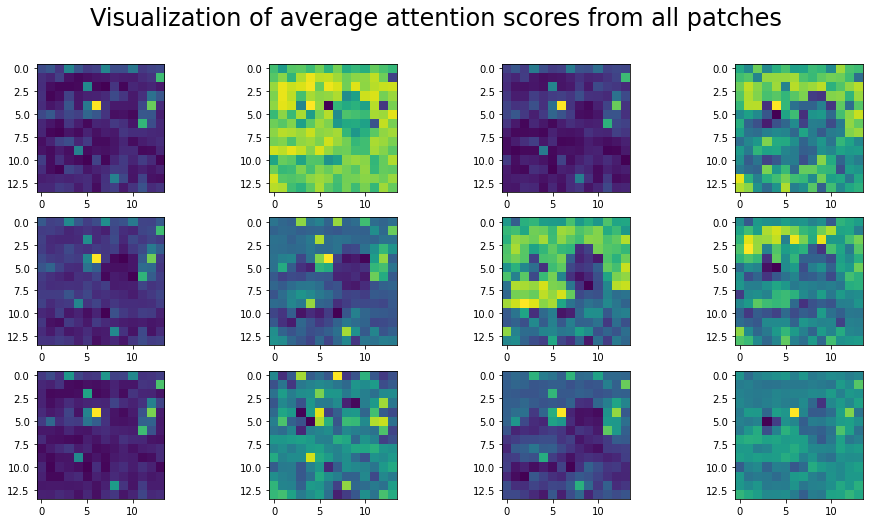

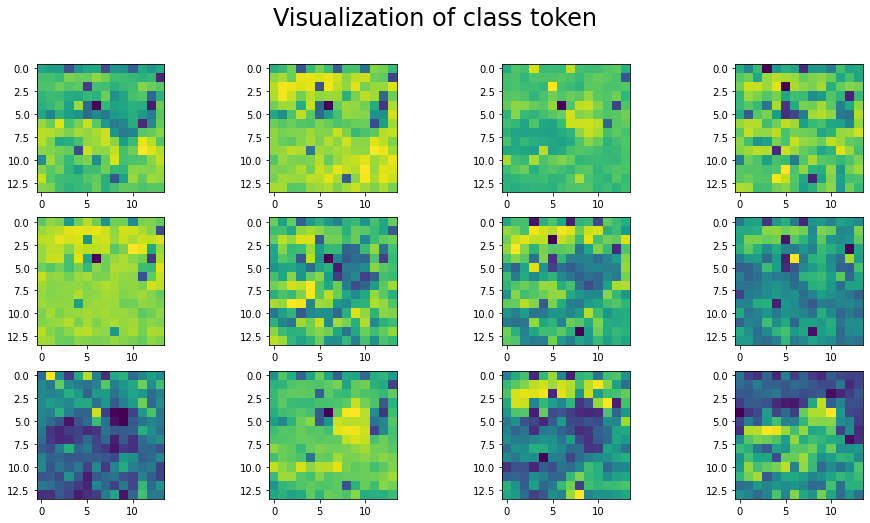

In [555]:
attn_mean = torch.mean(attention_matrix, axis = 1)
print(attn_mean.shape)
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of average attention scores from all patches", fontsize=24)
for i in range(12):
    head_mean = attn_mean[i, :]
    head_mean = head_mean[1:].reshape((14,14)).detach().cpu().numpy()
    print(f'max and min of head {i+1}: {np.max(head_mean)}, {np.min(head_mean)}')
    ax = fig.add_subplot(3, 4, i+1)
    ax.imshow(head_mean)
    
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of class token", fontsize=24)
for i in range(12):
    cls_token = attention_matrix[i, 1:, 0].reshape((14,14)).detach().cpu().numpy()
    ax = fig.add_subplot(3, 4, i+1)
    ax.imshow(cls_token)

"""fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
cls_token_mean = torch.mean(attention_matrix[:,1:,0], axis = 0)
cls_token_mean = cls_token_mean.reshape((14,14)).detach().cpu().numpy()
ax.imshow(cls_token_mean)"""

## MLP Classification Head

Classification head:  Linear(in_features=768, out_features=1000, bias=True)
Inference result : id = 497, label name = church, church_building



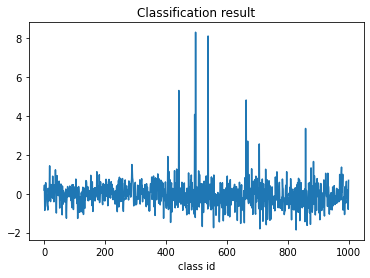

In [381]:
print("Classification head: ", model.head)
result = model.head(transformer_output)
result_label_id = int(torch.argmax(result))
plt.plot(result.detach().cpu().numpy()[0])
plt.title("Classification result")
plt.xlabel("class id")
print("Inference result : id = {}, label name = {}".format(
    result_label_id, imagenet_labels[result_label_id]))